https://stepik.org/lesson/209091/step/10

In [ ]:
import torch
import random
import numpy as np

# Устанавливаем начальные значения для генераторов случайных чисел для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
# Загружаем данные MNIST для обучения и тестирования
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [ ]:
# Доступ к данным и меткам
X_train = MNIST_train.train_data  # Изображения для обучения
y_train = MNIST_train.train_labels  # Метки для обучения
X_test = MNIST_test.test_data  # Изображения для тестирования
y_test = MNIST_test.test_labels  # Метки для тестирования

In [ ]:
len(y_train), len(y_test)  # Проверка количества элементов в обучающей и тестовой выборках

(60000, 10000)

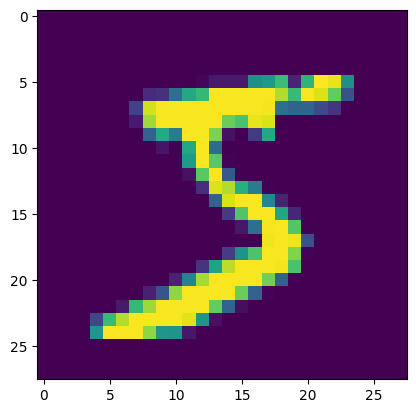

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
# Визуализируем первое изображение из обучающей выборки
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])  # Выводим соответствующую метку

In [ ]:
# Преобразуем данные в нужный формат для подачи в нейронную сеть (добавляем канал)
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape  # Проверяем форму данных после преобразования

torch.Size([60000, 1, 28, 28])

In [ ]:
# Определяем архитектуру LeNet-5
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Первый сверточный слой: 1 канал входа, 6 каналов выхода, ядро 5x5, паддинг 2
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()  # Активационная функция Tanh
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)  # Слой подвыборки (пулинг)

        # Второй сверточный слой: 6 каналов входа, 16 каналов выхода, ядро 5x5
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        # Полносвязный слой с 120 нейронами
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        # Полносвязный слой с 84 нейронами
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        # Выходной слой на 10 классов (цифры 0-9)
        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Прямое распространение данных через сеть
        x = self.conv1(x)  # Первый сверточный слой
        x = self.act1(x)  # Активация
        x = self.pool1(x)  # Пулинг

        x = self.conv2(x)  # Второй сверточный слой
        x = self.act2(x)  # Активация
        x = self.pool2(x)  # Пулинг

        # Преобразование тензора в вектор перед подачей в полносвязные слои
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        # Полносвязные слои
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# Создаем экземпляр модели LeNet5
lenet5 = LeNet5()

In [ ]:
# Проверяем наличие GPU и переводим модель на устройство (CPU или GPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [ ]:
# Определяем функцию потерь и оптимизатор
loss = torch.nn.CrossEntropyLoss()  # Кросс-энтропия для многоклассовой классификации
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)  # Adam оптимизатор с малым шагом

In [ ]:
batch_size = 256  # Размер мини-выборки

# История точности и потерь на тестовой выборке
test_accuracy_history = []
test_loss_history = []

# Переводим данные тестовой выборки на устройство
X_test = X_test.to(device)
y_test = y_test.to(device)

# Обучение модели
for epoch in range(100):
    # Перемешиваем индексы обучающей выборки
    order = np.random.permutation(len(X_train))

    # Цикл по мини-выборкам
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты

        # Получаем индексы для текущей мини-выборки
        batch_indexes = order[start_index:start_index+batch_size]

        # Загружаем мини-выборку на устройство
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        # Прямое распространение (предсказание)
        preds = lenet5.forward(X_batch)

        # Вычисляем значение функции потерь
        loss_value = loss(preds, y_batch)
        loss_value.backward()  # Обратное распространение ошибки

        optimizer.step()  # Шаг оптимизации

    # Тестирование модели на тестовой выборке
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())  # Сохраняем потери
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()  # Вычисляем точность
    test_accuracy_history.append(accuracy)  # Сохраняем точность

    print(accuracy)  # Выводим точность на каждом шаге обучения

# Код создает и обучает модель LeNet-5 для классификации рукописных цифр из датасета MNIST.

tensor(0.9681)
tensor(0.9789)
tensor(0.9819)
tensor(0.9869)
tensor(0.9856)
tensor(0.9881)
tensor(0.9872)
tensor(0.9887)
tensor(0.9892)
tensor(0.9887)
tensor(0.9900)
tensor(0.9885)
tensor(0.9895)
tensor(0.9878)
tensor(0.9900)
tensor(0.9902)
tensor(0.9899)
tensor(0.9899)
tensor(0.9902)
tensor(0.9864)
tensor(0.9887)
tensor(0.9893)
tensor(0.9895)
tensor(0.9886)
tensor(0.9876)
tensor(0.9889)
tensor(0.9904)
tensor(0.9891)
tensor(0.9880)
tensor(0.9886)
tensor(0.9877)
tensor(0.9901)
tensor(0.9891)
tensor(0.9897)
tensor(0.9892)
tensor(0.9896)
tensor(0.9906)
tensor(0.9907)
tensor(0.9868)
tensor(0.9884)
tensor(0.9902)
tensor(0.9899)
tensor(0.9904)
tensor(0.9907)
tensor(0.9906)
tensor(0.9904)
tensor(0.9906)
tensor(0.9906)
tensor(0.9908)
tensor(0.9906)
tensor(0.9905)
tensor(0.9907)
tensor(0.9908)
tensor(0.9906)
tensor(0.9908)
tensor(0.9905)
tensor(0.9909)
tensor(0.9906)
tensor(0.9908)
tensor(0.9912)
tensor(0.9910)
tensor(0.9909)
tensor(0.9910)
tensor(0.9911)
tensor(0.9908)
tensor(0.9911)
tensor(0.9

tensor(0.9913)


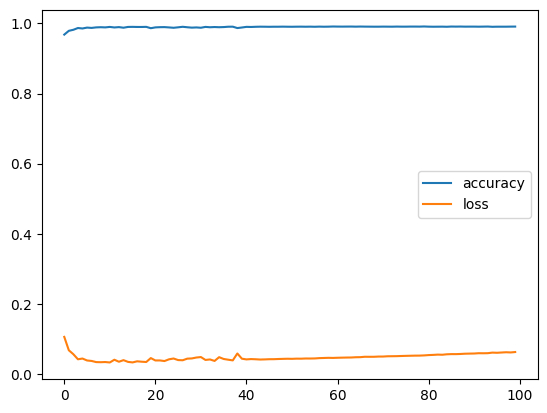

In [ ]:
print(max(test_accuracy_history))

import matplotlib.pyplot as plt

plt.plot(test_accuracy_history);
plt.plot(test_loss_history)
# вывести легенду
plt.legend(['accuracy', 'loss'])